In [1]:
import torch
from utils import *
import copy
from transformers import AutoModelForImageClassification
import matplotlib.pyplot as plt

/home/archy2/luke/Sparsity/.sparsity_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_SVD(W,rank):
  Uw, Sw, Vw = torch.svd(W)
  Sw[rank:] = 0
  W_svd = Uw @ torch.diag(Sw) @ Vw.T

  return W_svd

#Assumes square matrix
def get_Structural_Pruning(W,sparsity):
  W = copy.deepcopy(W)
  n = W.size(0)
  num_neurons_to_prune = int(n*sparsity)
  values, indices = indices_to_prune = torch.topk(torch.sum(torch.abs(W),dim=0), num_neurons_to_prune, largest=False)
  W[indices,:] = 0
  return W

def get_24(W):
  W = copy.deepcopy(W)
  for i in range(0, W.size(0), 2):
    for j in range(0, W.size(1), 2):
      threshold = torch.sort(torch.abs(torch.flatten(W[i:i+2,j:j+2])))[0][1]
      W[i:i+2,j:j+2] = W[i:i+2,j:j+2] * (W[i:i+2,j:j+2] > threshold)

  return W


def get_DRONE(W,rank,X):

  Uw, Sw, Vw = torch.svd(W)
  Ux, Sx, Vx = torch.svd(X)
  Sw, Sx = torch.diag(Sw), torch.diag(Sx)

  Z = Sw @ Vw.T @ Ux @ Sx
  Uz, Sz, Vz = torch.svd(Z)
  Sz[rank:] = 0
  Sz = torch.diag(Sz)

  Ustar = W @ Vw @ torch.inverse(Sw) @ Uz @ Sz
  VstarT = Vz.T @ torch.inverse(Sx) @ Ux.T
  W_drone = Ustar @ VstarT

  return W_drone

def get_Monarch(W):
  n = W.size(0)
  m = int(n**(1/2))
  W_monarch = copy.deepcopy(W)
  for i in range(m):
    for j in range(m):
      Um,Sm,Vm = torch.svd(W_monarch[i*m:(i+1)*m, j*m:(j+1)*m])
      Sm[1:] = 0
      W_monarch[i*m:(i+1)*m, j*m:(j+1)*m] = Um @ torch.diag(Sm) @ Vm.T

  return W_monarch 
 
def get_DRONE_Monarch(W, X):
  n = W.size(0)
  m = int(n**(1/2))
  print(m)

  W = copy.deepcopy(W)
  for i in range(m):
    x = X[i*m:(i+1)*m,:] #little x block
    for j in range(m):
      w = W[i*m:(i+1)*m, j*m:(j+1)*m] #little w block
      
      Uw, Sw, Vw = torch.svd(w)
      Ux, Sx, Vx = torch.svd(x)
      Sw, Sx = torch.diag(Sw), torch.diag(Sx)

      Z = Sw @ Vw.T @ Ux @ Sx
      Uz, Sz, Vz = torch.svd(Z)
      Sz[1:] = 0
      Sz = torch.diag(Sz)

      Ustar = w @ Vw @ torch.inverse(Sw) @ Uz @ Sz
      VstarT = Vz.T @ torch.inverse(Sx) @ Ux.T
      W[i*m:(i+1)*m, j*m:(j+1)*m] = Ustar @ VstarT

  return W

def get_Monarch_SVD(W, rank):
   
   W_svd = get_SVD(W, rank)
   W_diff = W - W_svd
   W_monarch = get_Monarch(W_diff)

   return W_svd + W_monarch

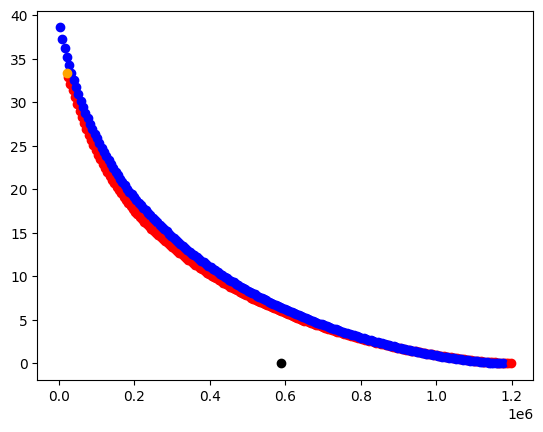

In [6]:
device = torch.device('cuda:0')
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224").to(device)

W_proj = model.vit.encoder.layer[0].attention.output.dense.weight.data

U,S,V = torch.svd(W_proj)

for rank in range(2, W_proj.size(0), 8):
    #Low Rank
    norm = torch.sum(S[rank:]**2).item()**(1/2)
    params = rank*(W_proj.size(0)+W_proj.size(1))
    plt.scatter(params, norm, label = f'Rank {rank}', color = 'blue')

    #Low Rank + Monarch
    W_lr = U[:,:rank] @ torch.diag(S[:rank]) @ V.T[:rank,:]
    norm = torch.norm(W_proj - get_Monarch(W_proj-W_lr) - W_lr).item()
    params = W_proj.size(0)**(3/2) + rank*(W_proj.size(0)+W_proj.size(1))
    plt.scatter(params, norm, label = f'Rank {rank} + Monarch', color = 'red')

#Dense
plt.scatter(768**2, 0, label = f'Dense', color = 'black')

#Monarch
norm = torch.norm(W_proj - get_Monarch(W_proj)).item()
params = W_proj.size(0)**(3/2)
plt.scatter(params, norm, label = f'Monarch', color = 'orange')
plt.show()

In [78]:
device = torch.device('cuda:0')
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224").to(device)

#Store results here
ranks = [4,8,16,24,27,32,64,96,128,192,256]
sparsities = [.1,.2,.3,.4,.5,.6,.7,.8]
modules = ['W_proj', 'W_q', 'W_k', 'W_v']# 'W_fc1', 'W_fc2']
method_names = ['svd_'+str(rank) for rank in ranks] + ['monarch'] + ['monarch_svd_'+str(rank) for rank in ranks] + ['sparse_' + str(s) for s in sparsities] + ['2:4']

Norm = {}
for name in method_names:
    Norm[name] = {}
    for module in modules:
        Norm[name][module] = []

for l in range(len(model.vit.encoder.layer)):

    W_proj = model.vit.encoder.layer[l].attention.output.dense.weight.data

    W_q = model.vit.encoder.layer[l].attention.attention.query.weight.data
    W_k = model.vit.encoder.layer[l].attention.attention.key.weight.data
    W_v = model.vit.encoder.layer[l].attention.attention.value.weight.data

    #W_fc1 = model.vit.encoder.layer[l].intermediate.dense.weight.data #3072,768
    #W_fc1_blocks = W_fc1[:768], W_fc1[768:2*768], W_fc1[2*768:3*768], W_fc1[3*768:]

    #W_fc2 = model.vit.encoder.layer[l].output.dense.weight.data #768,3072
    #W_fc2_blocks = W_fc2[:,:768], W_fc2[:,768:2*768], W_fc2[:,2*768:3*768], W_fc2[:,3*768:]

    for i in range(len(method_names)):
        if i < len(ranks):
            #SVD
            params = 768*2*ranks[i]
            method = lambda x: get_SVD(x, ranks[i])
        elif i == len(ranks):
            #Monarch
            params = 768*2*27+2*768-1
            method = lambda x: get_Monarch(x)
        elif i < len(ranks)*2+1:
            #Monarch + SVD
            params = 768*2*27+2*768-1 + 768*2*ranks[i-len(ranks)-1]
            method = lambda x: get_Monarch_SVD(x, ranks[i-len(ranks)-1])
        elif i < len(ranks)*2+1+len(sparsities):
            #Sparsity
            params = (1-sparsities[i-len(ranks)*2-1])*768**2
            method = lambda x: get_Structural_Pruning(x, sparsities[i-len(ranks)*2-1])
        else:
            params = 768**2 / 2
            method = lambda x: get_24(x)
            
        Norm[method_names[i]]['W_proj'].append((params, torch.norm(W_proj - method(W_proj)).item()))
        Norm[method_names[i]]['W_q'].append((params, torch.norm(W_q - method(W_q)).item()))
        Norm[method_names[i]]['W_k'].append((params, torch.norm(W_k - method(W_k)).item())) 
        Norm[method_names[i]]['W_v'].append((params, torch.norm(W_v - method(W_v)).item())) 

KeyboardInterrupt: 

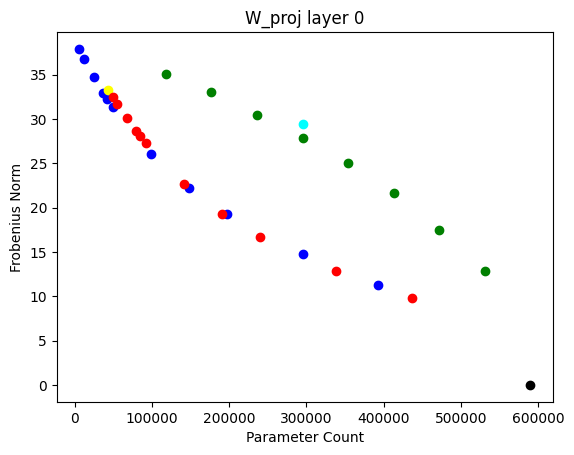

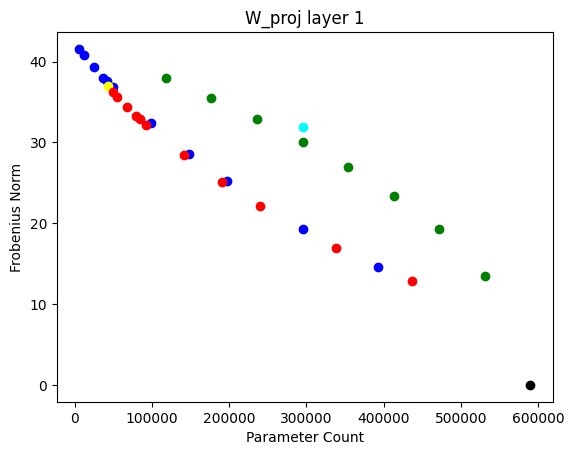

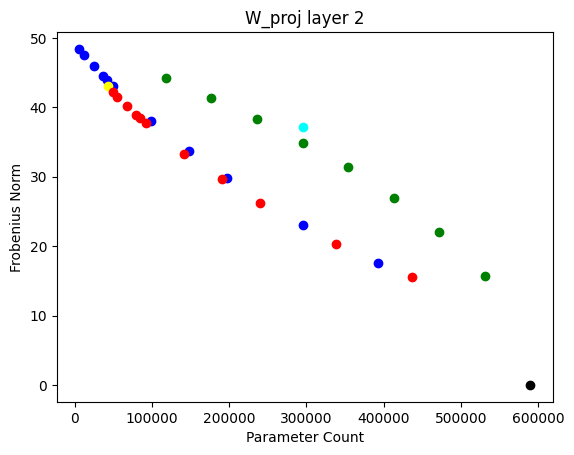

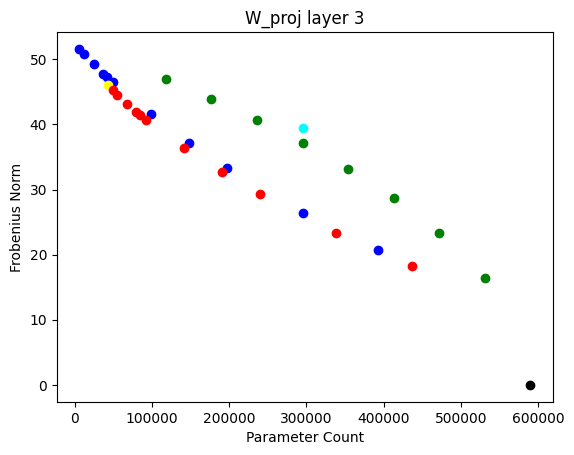

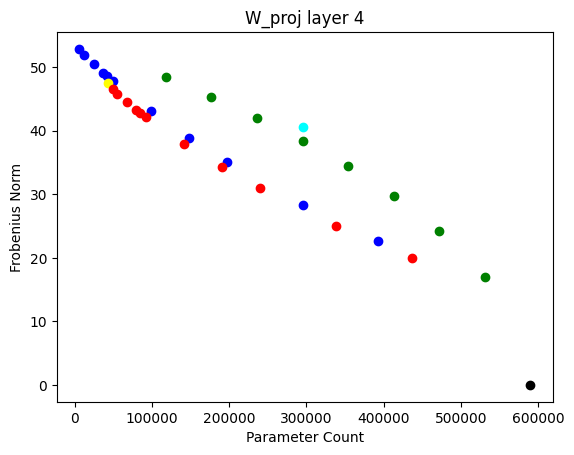

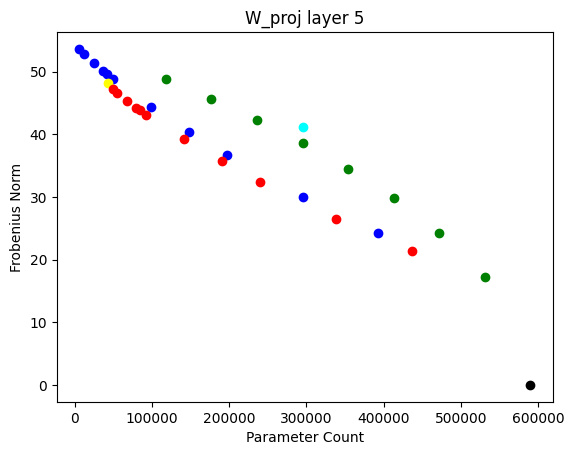

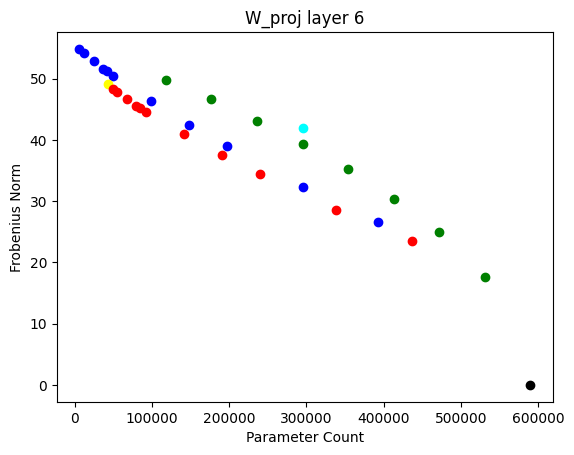

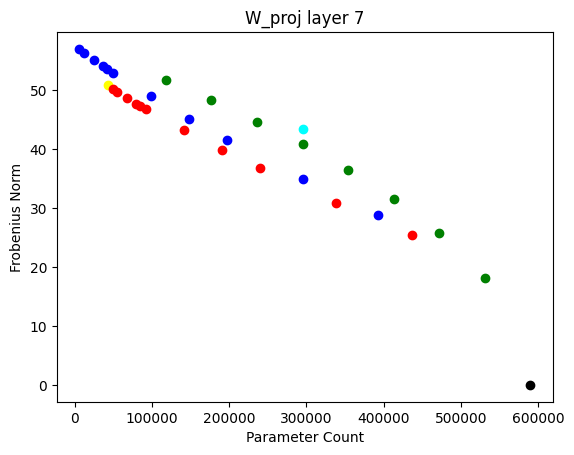

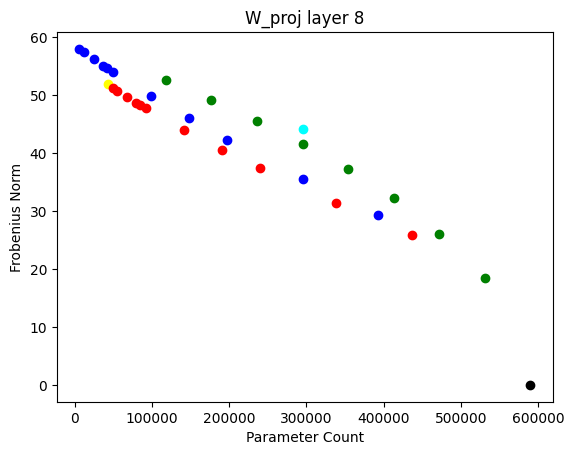

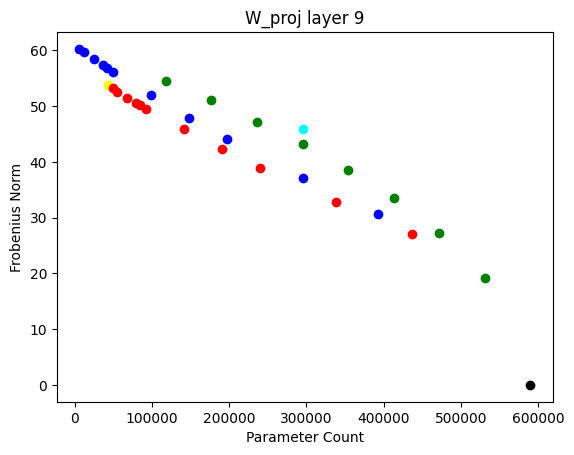

IndexError: list index out of range

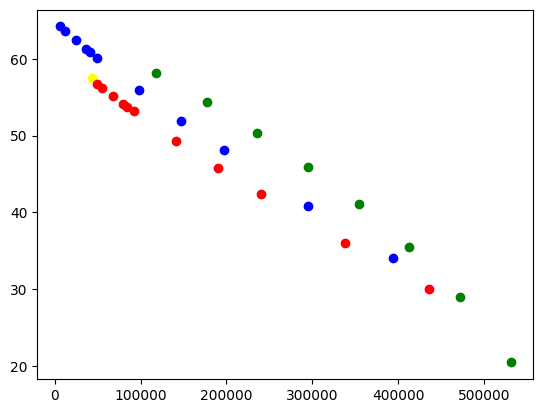

In [79]:
modules = ['W_proj', 'W_q', 'W_k', 'W_v']
for module in modules:
    for layer in range(len(model.vit.encoder.layer)):
        plt.Figure()
        for method in method_names:
            if method == 'monarch':
                color = 'yellow'
            elif 'monarch' in method:
                color = 'red'
            elif 'spar' in method:
                color = 'green'
            elif '2:4' in method:
                color = 'cyan'
            else:
                color = 'blue'
            x,y = Norm[method][module][layer]
            plt.scatter(x, y, label = method, color=color)
        plt.scatter(768*768, 0, label = method, color='black')
        #plt.legend()
        plt.xlabel('Parameter Count')
        plt.ylabel('Frobenius Norm')
        plt.title(module + ' layer ' + str(layer))
        plt.show()
    